<a href="https://colab.research.google.com/github/g8428/TIL/blob/master/220224_deeplearing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import numpy as np

In [83]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    #forward
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y

    #backward
    #dout : 상류에서 흘러오는 값
    def backward(self, dout):
        dx = dout*self.y
        dy = dout*self.x

        return dx, dy


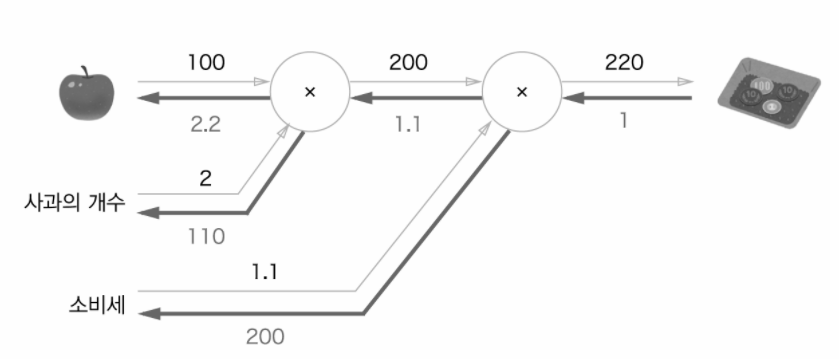

In [84]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#forward (전방향)
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

#barward (역방향)
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(f"price : {price}")
print(f"dapple : {dapple}")
print(f"dapple_num : {dapple_num}")
print(f"dtax : {dtax}")

price : 220.00000000000003
dapple : 2.2
dapple_num : 110.00000000000001
dtax : 200


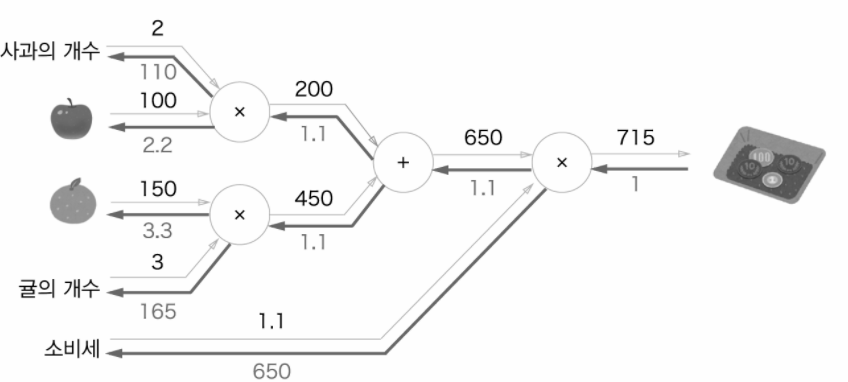

In [85]:
# 덧셈노드
class AddLayer:
    def forward(self,x,y):
        return x + y
    
    def backward(self,dout):
        dx = dout
        dy = dout
        return dx, dy

In [86]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 노드 객체 생성
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
mul_tax_layer = MulLayer()
add_apple_orange_layer = AddLayer()


#forward (전방향)
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

#barward (역방향)
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(f"price : {price}")
print(f"dapple : {dapple}")
print(f"dapple_num : {dapple_num}")
print(f"dorange : {dorange}")
print(f"dorange_num : {dorange_num}")
print(f"dtax : {dtax}")

price : 715.0000000000001
dapple : 2.2
dapple_num : 110.00000000000001
dorange : 3.3000000000000003
dorange_num : 165.0
dtax : 650


## Relu 역전파

In [87]:
# Relu 함수의 역전파

class Relu:
    def __init__(self):
        self.mask = None
    
    # x는 보통 array로 들어온다
    # self.mask에 조건을 주면 T/F로 값들을 필터
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()

        # x 중에서 0보다 작은 값 0으로 바꾸기
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        # dout은 y를 미분한 특정값, y 아웃풋이 아님
        dout[self.mask] = 0
        
        return dout

## Sigmoid의 역전파
시그모이드 함수
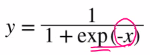

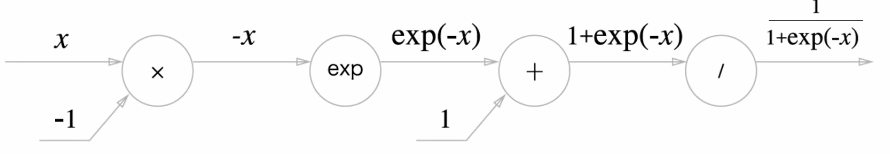

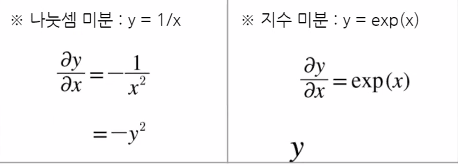

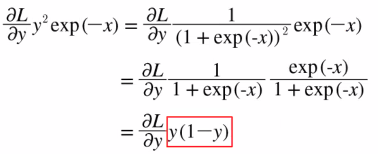

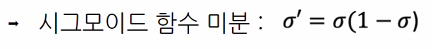

In [88]:
# 시그모이드 함수 미분
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [89]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self,x):
        self.out = sigmoid(x)
        return self.out
    
    def backward(self,dout):
        dx = dout * self.out(1 - self.out)
        return dx
        

## 행렬 노드의 계산 그래프

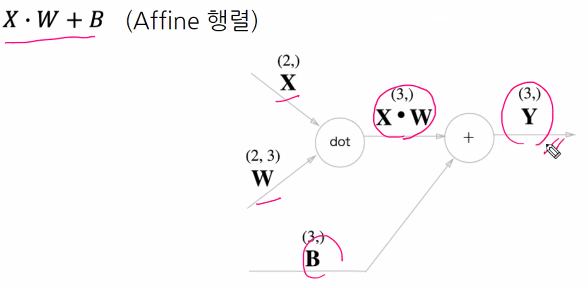

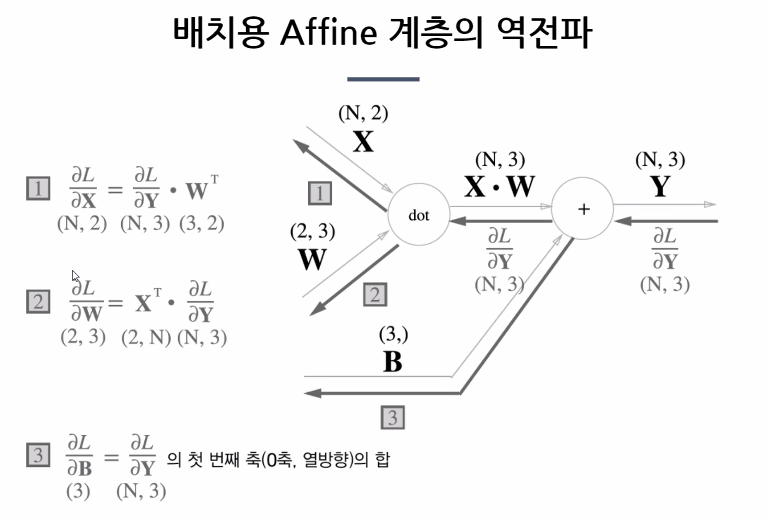

X와 W의 차원을 맞추기 위해 역행렬

In [90]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x

        # x * W + b
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)

        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0) # 첫번째 축(0번째 열방향)의 합

        return dx

## SoftMax의 역전파

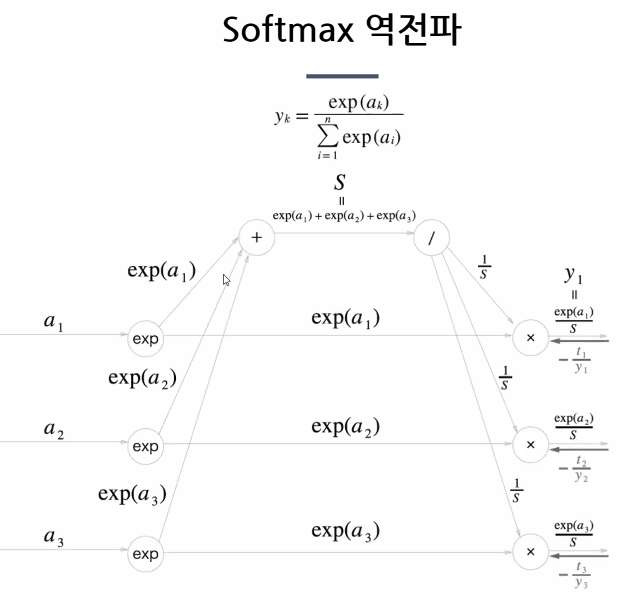

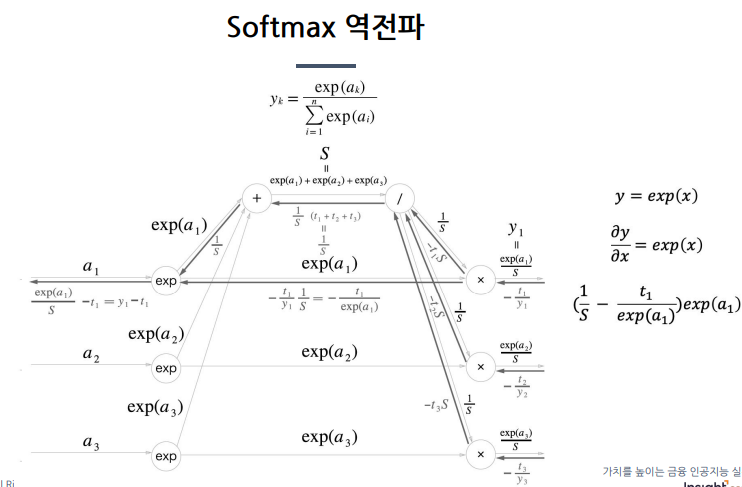

결론은 a1에 대한 softmax역전파는 $y_1 - t_1(라벨값)$

## Cross Entropy 역전파

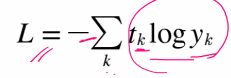

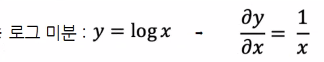

#### 결론 
$y_1역전파 = -\frac{t_1}{y_1}$

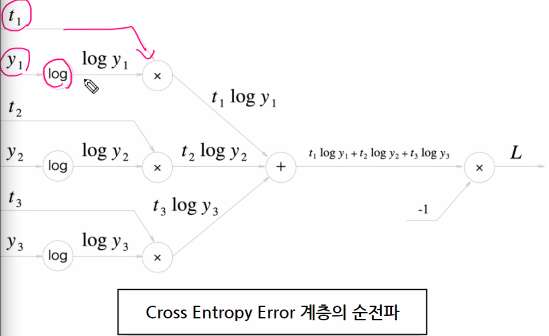

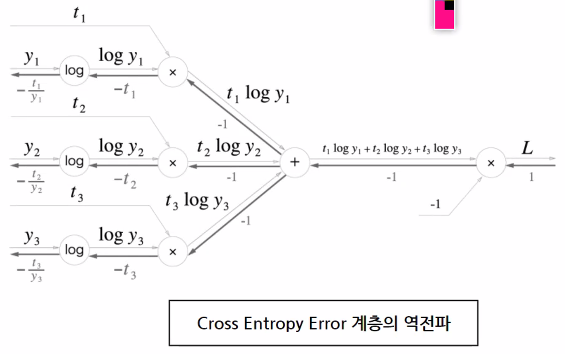

In [91]:
def softmax(x):
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x,axis= -1).reshape(-1,1) 
    # 제일 마지막 차원만 쓰겠다는 뜻 #제일 안에있는거 총합을 해야하니까
    y = exp_x / sum_exp_x

    return y

In [92]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]

    delta = 1e-7
    return -np.sum(t * np.log(y + delta))/batch_size

In [93]:
class SoftmaxWithLoss():
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss
        
    def backward(self, dout=1):

        # batch size 고려 -  샘플의 갯수
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t)/batch_size # 배치 사이즈 만큼 평균내기
        else:
            # 라벨이 원핫인코딩이 아니라 크기가 다른 경우
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

## 이제 값들을 미분해줘서 d값들 만들기

In [94]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        #f(x+h)
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)

        #f(x-h)
        x[idx] = float(tmp_val) - h 
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val

    return grad

In [95]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad

## 실습

In [96]:
from collections import OrderedDict


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 파라미터 랜덤 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 포워드&백워드 1 레이어 생성 + Relu
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        # 2레이어
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        # 3레이어(softmax)
        self.lastlayer = SoftmaxWithLoss()
    
    # 포워드 : 예측
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x) # output x를 다시 다음 layer input에 넣기
        
        return x
    
    # 손실 구하기
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y, t)

    # 정확도 구하기
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y,axis=1)

        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        
        accuracy = np.sum(y==t)/float(x.shape[0])
        return accuracy

    #각 파라미터의 기울기 구하기
    def numerical_gradient(self, x, t):
        #목적 함수 - Cross Entropy 
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        #목적함수에 대해 각 파라메터 별로 편미분
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.lastlayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse() # 뒤로가게 뒤집기

        for layer in layers:
            dout = layer.backward(dout) #dout값 레이어에 반복투입
        
        # 레이어에서 미분된 값 가져오기
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads



# 실습데이터 불러오기

In [97]:
import numpy as np
import pickle


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    def _change_one_hot_label(X):
        T = np.zeros((X.size, 10))
        for idx, row in enumerate(T):
            row[X[idx]] = 1

        return T


    with open('/content/drive/MyDrive/2022-1/국비지원교육/실습폴더/mnist.pkl의 사본', 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']),  (dataset['test_img'], dataset['test_label'])

In [98]:
#데이터 로딩  -  원핫 형식으로 
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True, flatten=True, one_hot_label=True) 

In [99]:
#2층 신경망 객체 생성
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [100]:
iters_num = 10000 #반복 횟수
train_size = x_train.shape[0] #훈련 데이터 크기
batch_size = 100 #미니배치 사이즈
learning_rate = 0.01 #학습률

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1) #1에폭당 반복 횟수, 최소 한번

In [ ]:
# 학습 진행

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size) #랜덤하게 0 ~ train_size -1 안에 있는 숫자를 batch_size 만큼 가져옴
    x_batch = x_train[batch_mask] #랜덤으로 batch_size 만큼 훈련 데이터에서 선택
    y_batch = y_train[batch_mask] #랜덤으로 batch_size 만큼 라벨에서 선택

    #각 파라미터의 gradient 계산
    grad = network.gradient(x_batch, y_batch)

    #각 파라미터를 업데이트 (EX, w = w - 학습률 * 기울기(미분값))
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    #loss 구하기
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss) #loss 값을 train_loss_list 추가

    if i % iter_per_epoch == 0:

        #파라미터 업데이트 후의 훈련 데이터 정확도
        train_acc = network.accuracy(x_train, y_train)
        #파라미터 업데이트 후의 테스트 데이터 정확도
        test_acc = network.accuracy(x_test, y_test)


        train_acc_list.append(train_acc) #accuracy 값을 train_acc_list에 추가 
        test_acc_list.append(test_acc) #accuracy 값을 test_acc_list에 추가 
        
        #파라미터 업데이트 후의 loss, train 정확도, test 정확도 출력
        print(f"loss {loss}, train_accuracy {train_acc}, test_accuracy {test_acc}")





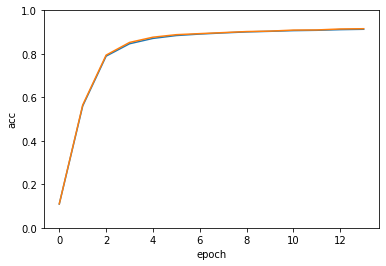

In [102]:
import matplotlib.pylab as plt

x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label = 'train acc')
plt.plot(x, test_acc_list, label = 'test acc')

plt.xlabel('epoch')
plt.ylabel('acc')

plt.ylim(0, 1.0)
plt.show()


## AdaGrad
    알파값 파라미터
    업데이트가 많이 적용된 때엔 작은 알파값 적용
    업데이터 조금 적용된 세타에는 큰 알파 적용